In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [2]:
from src.utils import pmf_utils

### Load Configs

In [3]:

from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)


## Load Data

In [4]:
aggregate_data = pd.read_csv(Path(raw_dir, "aggregate_data.csv"), index_col=None)
session_metadata = pd.read_csv(Path(raw_dir, "subject_metadata.csv"), index_col=None)
session_metadata.head()

,subject_id,prior_condition,treatment,off_med_first,file_name,is_tremor_dominant,bradykinesia_score,sMMSE,BDI,BAI,UPDRS,210_Tremor,301_Speech,302_Facial_Expression,303a_Rigidity_Neck,303b_Rigidity_RUE,303c_Rigidity_LUE,303d_Rigidity_RLE,303e_Rigidity_LLE,304a_Finger_Tapping_RUE,304b_Finger_Tapping_LUE,305a_Hand_Movements_RUE,305b_Hand_Movements_LUE,306a_Pronation_Subination_Movements_RUE,306b_Pronation_Subination_Movements_LUE,307a_Toe_Tapping_RLE,307b_Toe_Tapping_LLE,308a_Leg_Agility_RLE,308b_Leg_Agility_LLE,309_Arising_from_Chair,310_Gait,311_Freezing_of_Gait,312_Postural_Stability,313_Posture,314_Global_Spontaneity_of_Movement,315a_Posture_Tremor_RUE,315b_Posture_Tremor_LUE,316a_Kinetic_Tremor_RUE,316b_Kinetic_Tremor_LUE,317a_Rest_Tremor_Amplitude_RUE,317b_Rest_Tremor_Amplitude_LUE,317c_Rest_Tremor_Amplitude_RLE,317d_Rest_Tremor_Amplitude_LLE,317e_Rest_Tremor_Amplitude_Lip_Jaw,318_Constancy_of_Rest_Tremor,Were_Diskinesias_Present,Did_these_Movements_Interfere_with_Ratings,Hoehn_and_Yahr_Stage,notes
0,P1,NaN,OFF,1.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,1.0,0.0,1.0,1.0,0.0,2.0,NaN,NaN,1.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,no,2.0,NaN
1,P1,NaN,ON,1.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,no,2.0,NaN
2,P4,NaN,OFF,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,2.0,NaN,NaN,2.0,NaN
3,P4,NaN,ON,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,no,no,2.0,NaN
4,P6,NaN,OFF,1.0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,1.0,0.0,1.0,2.0,2.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,no,no,2.0,NaN


#### Fill out the subject_metadata prior based on aggregate_data

In [5]:
for subject, medication in sorted(list(zip(session_metadata['subject_id'], session_metadata['treatment'])), key = lambda x: x[0]):
    # find the corresponding row in the aggregate data
    session_data = aggregate_data[(aggregate_data['subject'] == subject) & (aggregate_data['medication'] == medication.lower())]
    prior = np.unique(session_data['prior'])
    prior = prior[prior != 'eq']

    # in session_metadata, where subject and medication matches, update the prior
    current_idx = session_metadata[(session_metadata['subject_id'] == subject) & (session_metadata['treatment'] == medication)].index
    session_metadata.loc[current_idx, 'prior_condition'] = prior[0]
    session_metadata.loc[current_idx, 'file_name'] = np.unique(session_data['session_name'])[0]

In [6]:
print(session_metadata.isnull().sum())

# replace null with NaN
session_metadata.replace('', np.nan, inplace=True)
session_metadata.replace('NA', np.nan, inplace=True)

subject_id                                     0
prior_condition                                0
treatment                                      0
off_med_first                                 14
file_name                                      0
is_tremor_dominant                            46
bradykinesia_score                            62
sMMSE                                         46
BDI                                           47
BAI                                           46
UPDRS                                         18
210_Tremor                                    46
301_Speech                                    30
302_Facial_Expression                         30
303a_Rigidity_Neck                            30
303b_Rigidity_RUE                             30
303c_Rigidity_LUE                             30
303d_Rigidity_RLE                             33
303e_Rigidity_LLE                             33
304a_Finger_Tapping_RUE                       30
304b_Finger_Tapping_

In [7]:
print("------------- info ----------------")
print(session_metadata.info())
print("\n\n------------- head ----------------\n\n")
print(session_metadata.head())
print("\n\n------------- describe ----------------\n\n")
print(session_metadata.describe())
print("\n\n------------- dtypes ----------------\n\n")
print(session_metadata.dtypes)
print("\n\n------------- shape ----------------\n\n")
print(session_metadata.shape)

------------- info ----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   subject_id                                  62 non-null     object 
 1   prior_condition                             62 non-null     object 
 2   treatment                                   62 non-null     object 
 3   off_med_first                               48 non-null     float64
 4   file_name                                   62 non-null     object 
 5   is_tremor_dominant                          16 non-null     float64
 6   bradykinesia_score                          0 non-null      float64
 7   sMMSE                                       16 non-null     float64
 8   BDI                                         15 non-null     float64
 9   BAI                                         16 non-nu

##### Data rejection

In [8]:
valid_data = aggregate_data[aggregate_data['is_valid'] == 1]
# chose trials with minimum reaction time from main_config
valid_data = valid_data[valid_data['reaction_time'] >= main_config.BEHAVIOR.min_rt]

#### Direction and color conversion to prior condition

In [9]:
# Ensure valid_data is a DataFrame you intend to modify directly
def data_preprocessing(data):

    # remove data from subjects listed in main_config.manual_rejection
    data = data[~data['subject'].isin(main_config.manual_rejection)]
    # remove equal prior sessions
    data = data[data['prior'] != 'eq']
    data['prior_color'].loc[data['prior'] == 'eq'] = np.NaN
    data['prior_direction'].loc[data['prior'] == 'eq'] = np.NaN

    left_prior_idx = data['prior_direction'] == 'left'
    right_prior_idx = data['prior_direction'] == 'right'
    green_prior_idx = data['prior_color'] == 'green'
    red_prior_idx = data['prior_color'] == 'red'

    # Renaming directions based on prior direction
    data.loc[left_prior_idx, 'target'] = data.loc[left_prior_idx, 'target'].map({'left': 1, 'right': -1})
    data.loc[left_prior_idx, 'choice'] = data.loc[left_prior_idx, 'choice'].map({'left': 1, 'right': -1})
    data.loc[right_prior_idx, 'target'] = data.loc[right_prior_idx, 'target'].map({'left': -1, 'right': 1})
    data.loc[right_prior_idx, 'choice'] = data.loc[right_prior_idx, 'choice'].map({'left': -1, 'right': 1})

    # Renaming colors based on prior color
    data.loc[green_prior_idx, 'color'] = data.loc[green_prior_idx, 'color'].map({'green': 1, 'red': -1})
    data.loc[red_prior_idx, 'color'] = data.loc[red_prior_idx, 'color'].map({'green': -1, 'red': 1})

    data['signed_coherence'] = data['coherence'] * data['target']

    return data

valid_data = data_preprocessing(valid_data)
aggregate_data = data_preprocessing(aggregate_data)

#### Rejecting sessions based on allowed lapse rates

In [10]:
sessions = valid_data['session_name'].unique()

reject_sessions = []

for session in sessions:
    session_data = valid_data[valid_data['session_name'] == session]
    for color in [-1, 1]:
        accuracy_100prct = np.mean(session_data['outcome'][np.abs(session_data['signed_coherence']) == 100])
        if accuracy_100prct < main_config.BEHAVIOR.min_easy_accuracy:
            reject_sessions.append(session)
            print(f"Subject: {session} rejected due to low accuracy {accuracy_100prct}")
            continue

aggregate_data = aggregate_data[~aggregate_data['session_name'].isin(reject_sessions)]
valid_data = valid_data[~valid_data['session_name'].isin(reject_sessions)]


Subject: RZA_OFFmeds_gl.mat rejected due to low accuracy 0.5921052631578947
Subject: RZA_OFFmeds_gl.mat rejected due to low accuracy 0.5921052631578947
Subject: RSH_ONmeds_gl.mat rejected due to low accuracy 0.5319148936170213
Subject: RSH_ONmeds_gl.mat rejected due to low accuracy 0.5319148936170213
Subject: SKU_OFFmeds_rr.mat rejected due to low accuracy 0.541095890410959
Subject: SKU_OFFmeds_rr.mat rejected due to low accuracy 0.541095890410959
Subject: SNO_ONmeds_rr.mat rejected due to low accuracy 0.5477707006369427
Subject: SNO_ONmeds_rr.mat rejected due to low accuracy 0.5477707006369427
Subject: RZA_ONmeds_rl.mat rejected due to low accuracy 0.5846153846153846
Subject: RZA_ONmeds_rl.mat rejected due to low accuracy 0.5846153846153846
Subject: P2_OFFmeds_gl.mat rejected due to low accuracy 0.5286624203821656
Subject: P2_OFFmeds_gl.mat rejected due to low accuracy 0.5286624203821656
Subject: P15_OFFmeds_gr.mat rejected due to low accuracy 0.4652777777777778
Subject: P15_OFFmeds_g

In [11]:
# finding subjects who have both on and off medication sessions
subject_sessions = valid_data.groupby('subject')['medication'].unique()

valid_subjects = []
for subject, sessions in subject_sessions.items():
    if len(sessions) == 2:
        valid_subjects.append(subject)

aggregate_data = aggregate_data[aggregate_data['subject'].isin(valid_subjects)]
valid_data = valid_data[valid_data['subject'].isin(valid_subjects)]
valid_session_metadata = session_metadata[session_metadata['subject_id'].isin(valid_subjects)]

print(f"Number of valid subjects: {len(valid_subjects)}")
print(valid_subjects)
print(f"Number of subjects: {len(valid_data['subject'].unique())}")
print(valid_data['subject'].unique())
print(f"Number of sessions: {len(valid_session_metadata['subject_id'].unique())}")
print(valid_session_metadata['subject_id'].unique())


Number of valid subjects: 35
['ALE', 'BBK', 'BER', 'CG', 'COH', 'DP', 'FUR', 'LBR', 'LHO', 'MAR', 'MBY', 'P1', 'P10', 'P11', 'P12', 'P13', 'P16', 'P17', 'P18', 'P19', 'P20', 'P22', 'P23', 'P24', 'P3', 'P4', 'P6', 'P7', 'P9', 'PAM', 'RBA', 'RDE', 'RW', 'SGA', 'SMI']
Number of subjects: 35
['PAM' 'ALE' 'P11' 'COH' 'P20' 'P16' 'CG' 'BER' 'P23' 'P6' 'MAR' 'RBA'
 'LBR' 'P12' 'LHO' 'SGA' 'P4' 'RDE' 'P10' 'RW' 'P17' 'DP' 'SMI' 'P13' 'P7'
 'P22' 'P9' 'FUR' 'P18' 'P1' 'P3' 'P24' 'P19' 'BBK' 'MBY']
Number of sessions: 31
['P1' 'P4' 'P6' 'P7' 'P9' 'P11' 'P12' 'P13' 'P16' 'P17' 'P18' 'P19' 'P20'
 'P22' 'P23' 'P24' 'CG' 'COH' 'MBY' 'DP' 'FUR' 'LBR' 'MAR' 'SMI' 'PAM'
 'RW' 'SGA' 'BBK' 'BER' 'RBA' 'RDE']


In [12]:
session_metadata['subject_id'].unique()

array(['P1', 'P4', 'P6', 'P7', 'P9', 'P11', 'P12', 'P13', 'P16', 'P17',
       'P18', 'P19', 'P20', 'P22', 'P23', 'P24', 'CG', 'COH', 'MBY', 'DP',
       'FUR', 'LBR', 'MAR', 'SMI', 'PAM', 'RW', 'SGA', 'BBK', 'BER',
       'RBA', 'RDE'], dtype=object)

In [13]:
# adding session_id to each subject off and on medication sessions

subject_sessions = valid_data.groupby('subject')['medication'].unique()

session_metadata['positive_bias'] = np.NaN
session_metadata['positive_bias'] = np.NaN
session_metadata['positive_psych_alpha'] = np.NaN
session_metadata['positive_psych_beta'] = np.NaN
session_metadata['positive_psych_lapse'] = np.NaN
session_metadata['positive_psych_guess'] = np.NaN

session_metadata['equal_psych_bias'] = np.NaN
session_metadata['equal_psych_bias'] = np.NaN
session_metadata['equal_psych_alpha'] = np.NaN
session_metadata['equal_psych_beta'] = np.NaN
session_metadata['equal_psych_lapse'] = np.NaN
session_metadata['equal_psych_guess'] = np.NaN

for subject, sessions in subject_sessions.items():
    for session in sessions:
        session_data = valid_data[(valid_data['subject'] == subject) & (valid_data['medication'] == session)]

        current_idx = session_metadata[(session_metadata['subject_id'] == subject) & (session_metadata['treatment'] == session.upper())].index

        positive_bias, positive_psych_bias, positive_psych_alpha, positive_psych_beta, positive_psych_lapse, positive_psych_guess = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
        equal_bias, equal_psych_bias, equal_psych_alpha, equal_psych_beta, equal_psych_lapse, equal_psych_guess = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN

        coh, positive_psych, positive_model, _, _, = pmf_utils.get_psychometric_data(session_data[session_data['color'] == 1])
        coh, equal_psych, equal_model, _, _, = pmf_utils.get_psychometric_data(session_data[session_data['color'] == -1])

        session_metadata.loc[current_idx, 'positive_bias'] = positive_psych[3]
        session_metadata.loc[current_idx, 'positive_psych_bias'] = positive_model.predict(0)
        session_metadata.loc[current_idx, 'positive_psych_alpha'] = positive_model.coefs_['mean']
        session_metadata.loc[current_idx, 'positive_psych_beta'] = positive_model.coefs_['var']
        session_metadata.loc[current_idx, 'positive_psych_lapse'] = positive_model.coefs_['lapse_rate']
        session_metadata.loc[current_idx, 'positive_psych_guess'] = positive_model.coefs_['guess_rate']

        session_metadata.loc[current_idx, 'equal_bias'] = equal_psych[3]
        session_metadata.loc[current_idx, 'equal_psych_bias'] = equal_model.predict(0)
        session_metadata.loc[current_idx, 'equal_psych_alpha'] = equal_model.coefs_['mean']
        session_metadata.loc[current_idx, 'equal_psych_beta'] = equal_model.coefs_['var']
        session_metadata.loc[current_idx, 'equal_psych_lapse'] = equal_model.coefs_['lapse_rate']
        session_metadata.loc[current_idx, 'equal_psych_guess'] = equal_model.coefs_['guess_rate']


### Input decision-behavior parameters into session_metadata

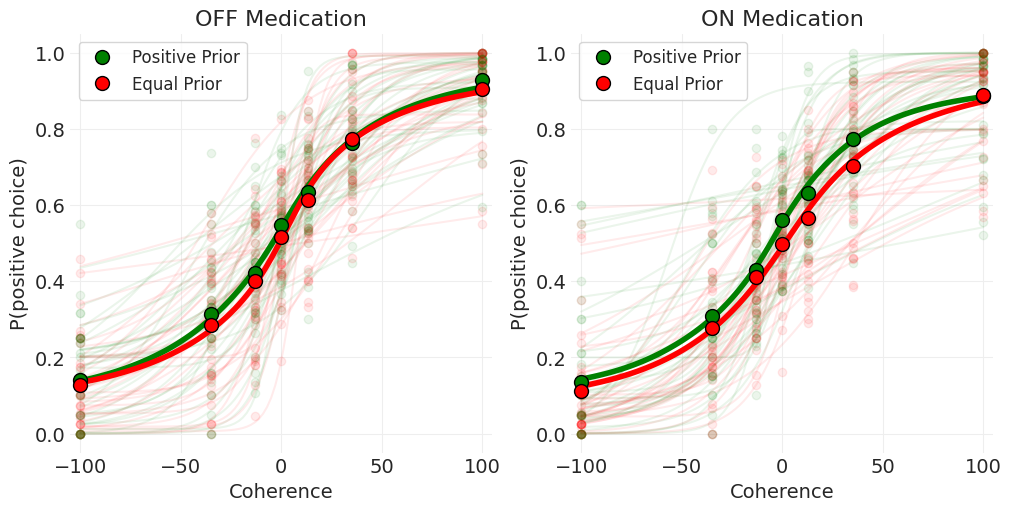

In [14]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
subject_alpha = 0.08

sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []


for i, subject in enumerate(valid_subjects):
    subject_data = valid_data[valid_data['subject'] == subject]
    subject_data = subject_data.sort_values('medication')

    subject_metadata = session_metadata.loc[session_metadata['subject_id'] == subject]
    if True:#  and np.sum(np.isnan(subject_metadata['categorization_score'])) == 0:

        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 1])
            eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == -1])

            if med == 'off':
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_psych.append(pos_psych)
                sub_off_pos_model.append(pos_model)
                sub_off_pos_x_hat.append(pos_x_hat)
                sub_off_pos_y_hat.append(pos_y_hat)
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_psych.append(eq_psych)
                sub_off_eq_model.append(eq_model)
                sub_off_eq_x_hat.append(eq_x_hat)
                sub_off_eq_y_hat.append(eq_y_hat)
            elif med == 'on':
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_psych.append(pos_psych)
                sub_on_pos_model.append(pos_model)
                sub_on_pos_x_hat.append(pos_x_hat)
                sub_on_pos_y_hat.append(pos_y_hat)
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_psych.append(eq_psych)
                sub_on_eq_model.append(eq_model)
                sub_on_eq_x_hat.append(eq_x_hat)
                sub_on_eq_y_hat.append(eq_y_hat)

            ax[ax_idx].plot(pos_coh, pos_psych, 'go', alpha=subject_alpha)
            ax[ax_idx].plot(pos_x_hat, pos_y_hat, 'g-', alpha=subject_alpha)
            ax[ax_idx].plot(eq_coh, eq_psych, 'ro', alpha=subject_alpha)
            ax[ax_idx].plot(eq_x_hat, eq_y_hat, 'r-', alpha=subject_alpha)

ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), np.mean(sub_off_pos_y_hat, axis=0), 'g-', lw=4, alpha=1)
ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), np.mean(sub_off_eq_y_hat, axis=0), 'r-', lw=4, alpha=1)
ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), 'go', ms=10, mec='k', label='Positive Prior', alpha=1)
ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), 'ro', ms=10, mec='k', label='Equal Prior', alpha=1)

ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), np.mean(sub_on_pos_y_hat, axis=0), 'g-', lw=4, alpha=1)
ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), np.mean(sub_on_eq_y_hat, axis=0), 'r-', lw=4, alpha=1)
ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), 'go', ms=10, mec='k', label='Positive Prior', alpha=1)
ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), 'ro', ms=10, mec='k', label='Equal Prior', alpha=1)

ax[0].set_title(f"OFF Medication", fontsize=16)
ax[0].set_xlabel('Coherence', fontsize=14)
ax[0].set_ylabel('P(positive choice)', fontsize=14)
ax[0].set_xlim(-105, 105)
ax[0].set_ylim(-0.05, 1.05)
ax[0].legend()
ax[1].set_title(f"ON Medication", fontsize=16)
ax[1].set_xlabel('Coherence', fontsize=14)
ax[1].set_ylabel('P(positive choice)', fontsize=14)
ax[1].set_xlim(-105, 105)
ax[1].set_ylim(-0.05, 1.05)
ax[1].legend()



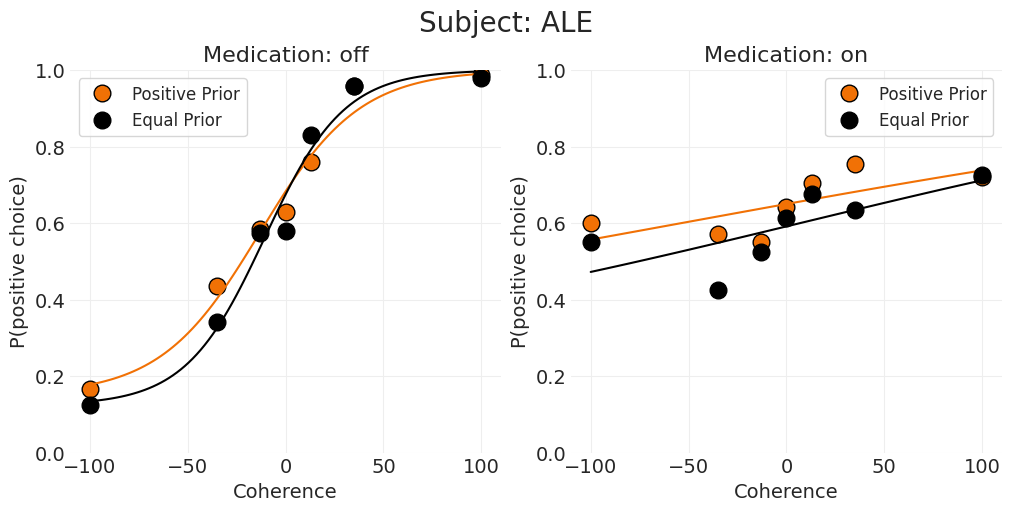

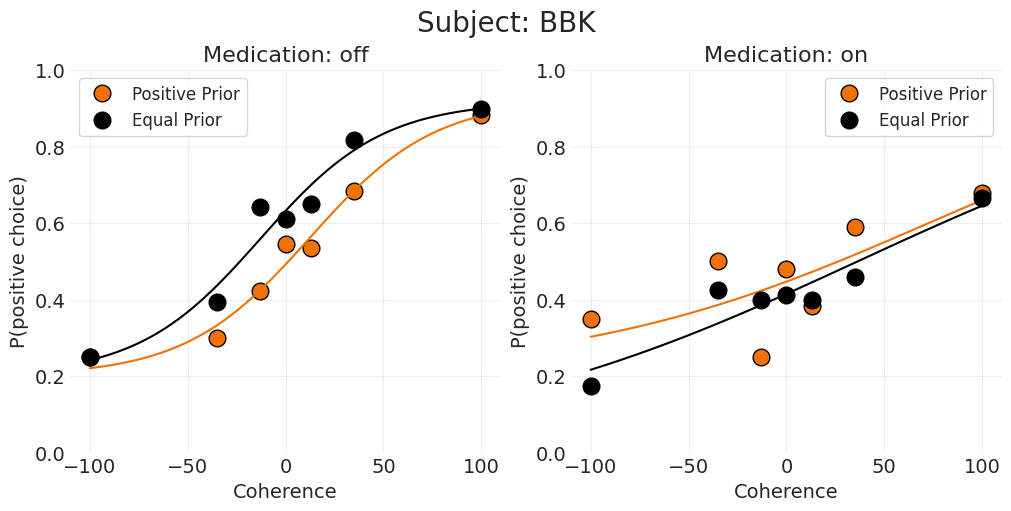

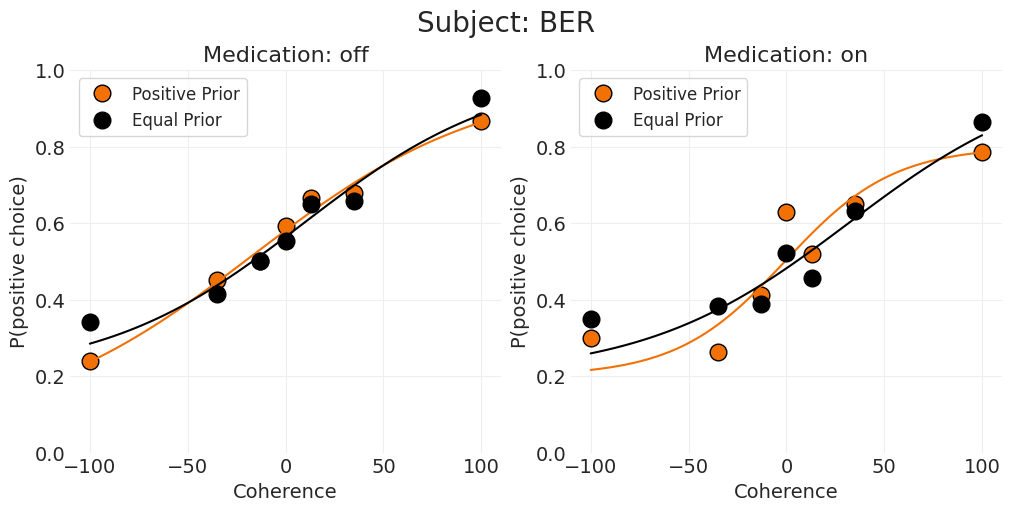

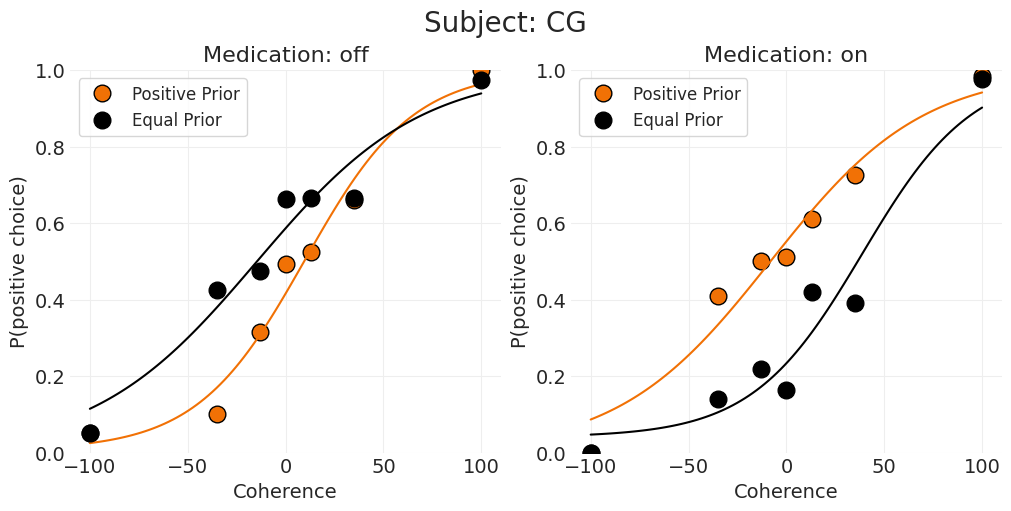

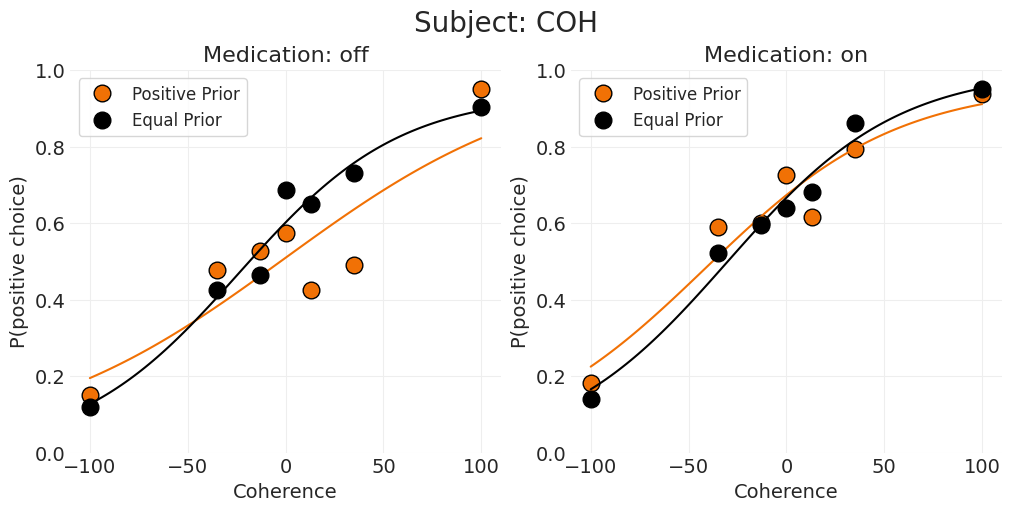

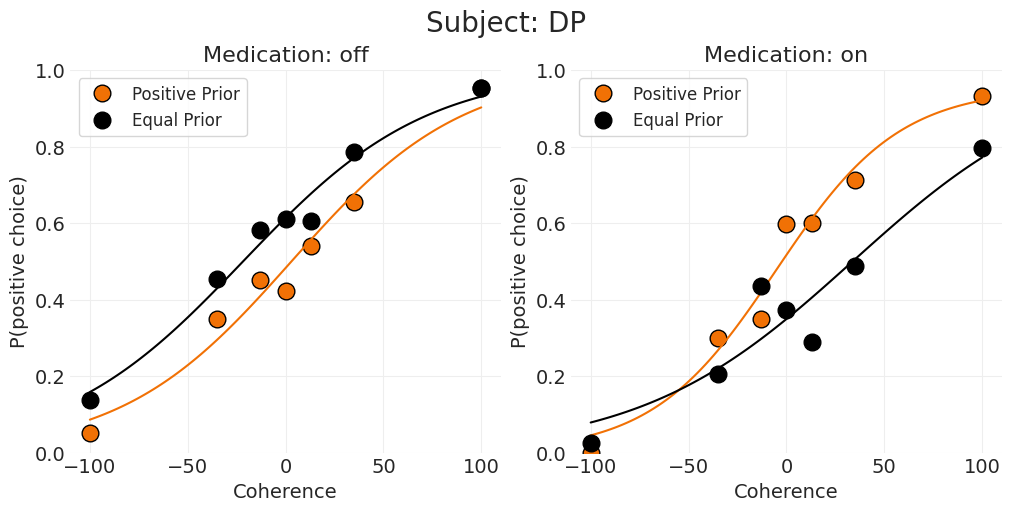

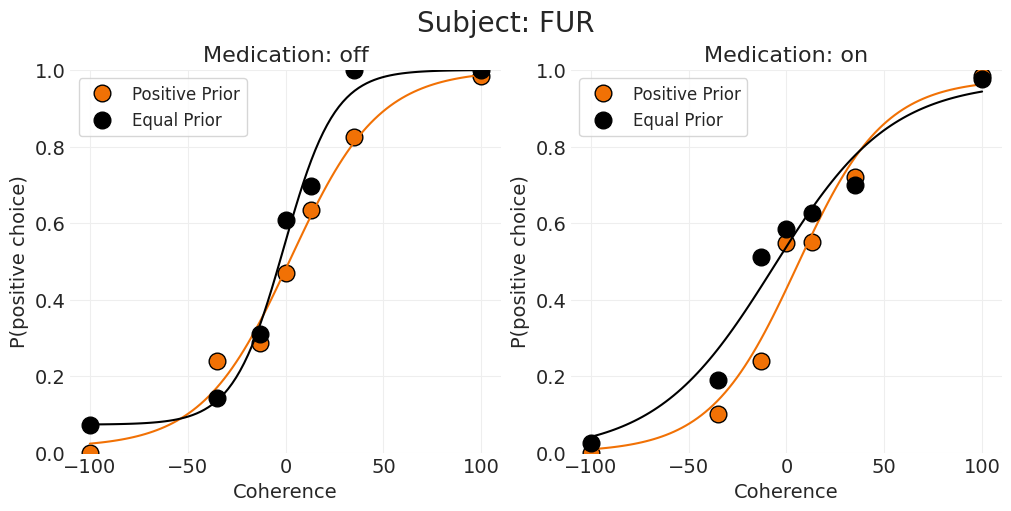

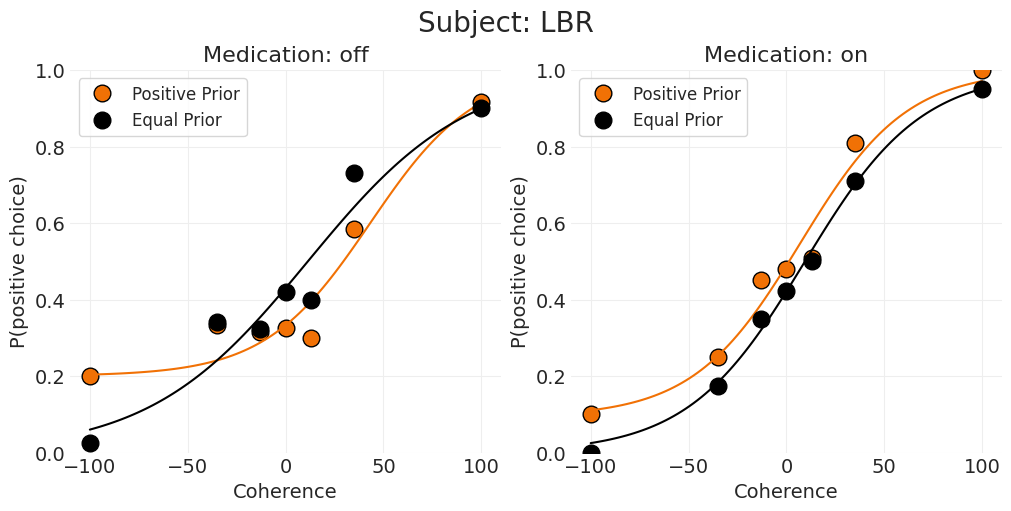

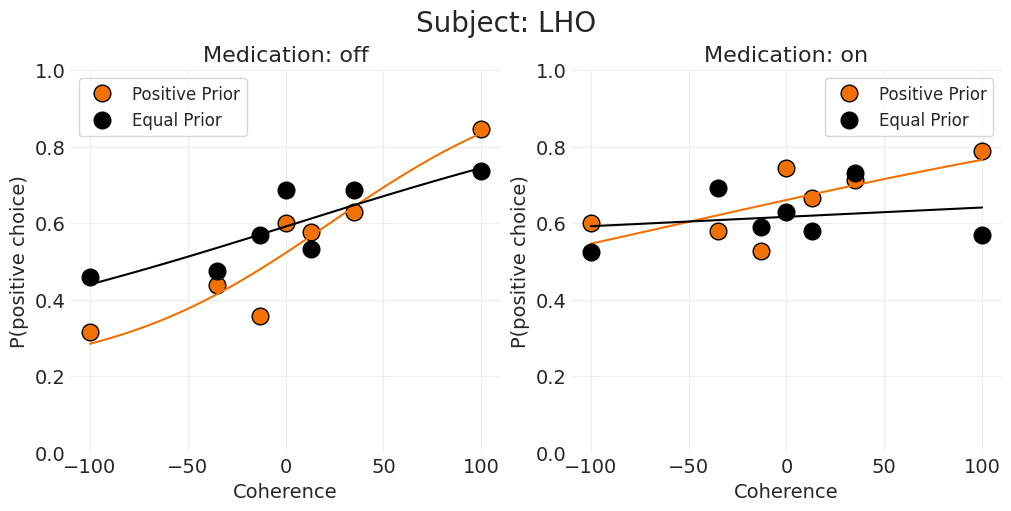

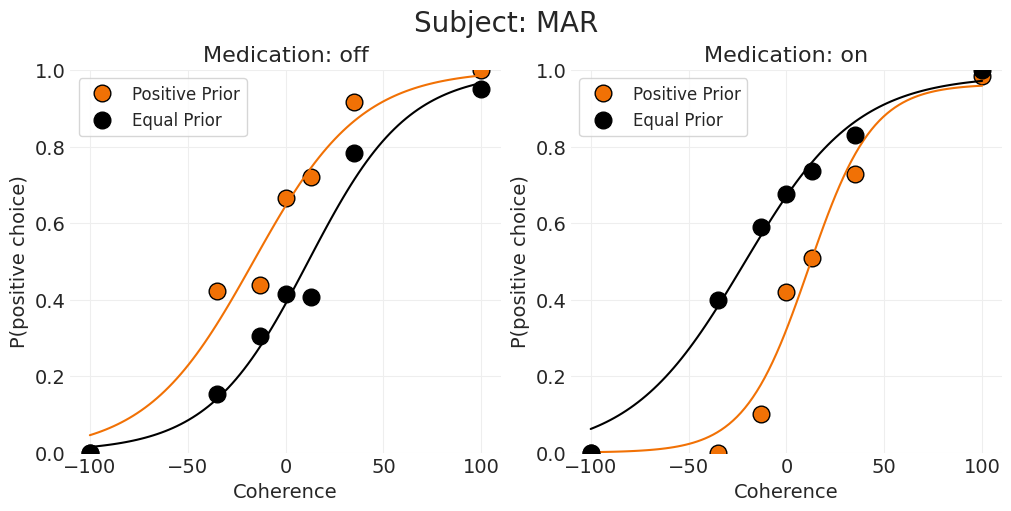

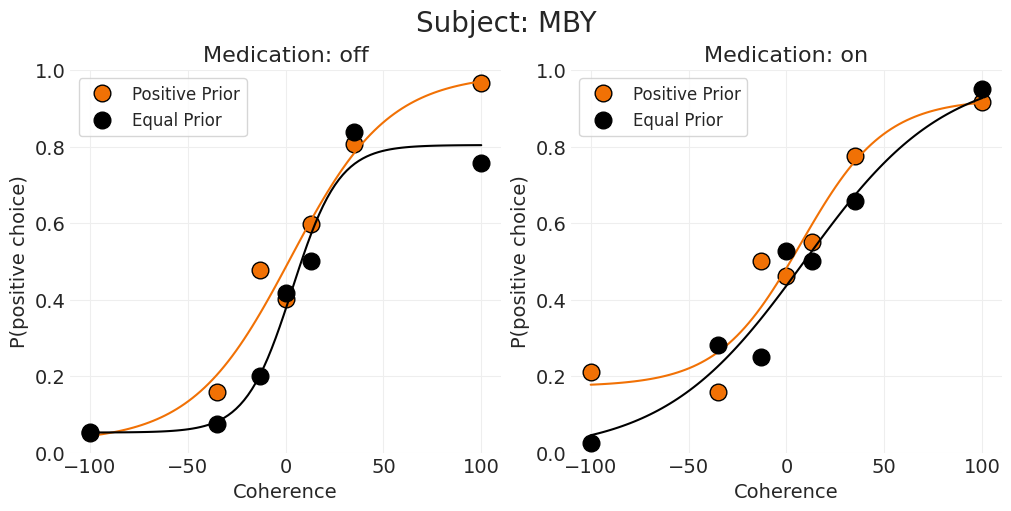

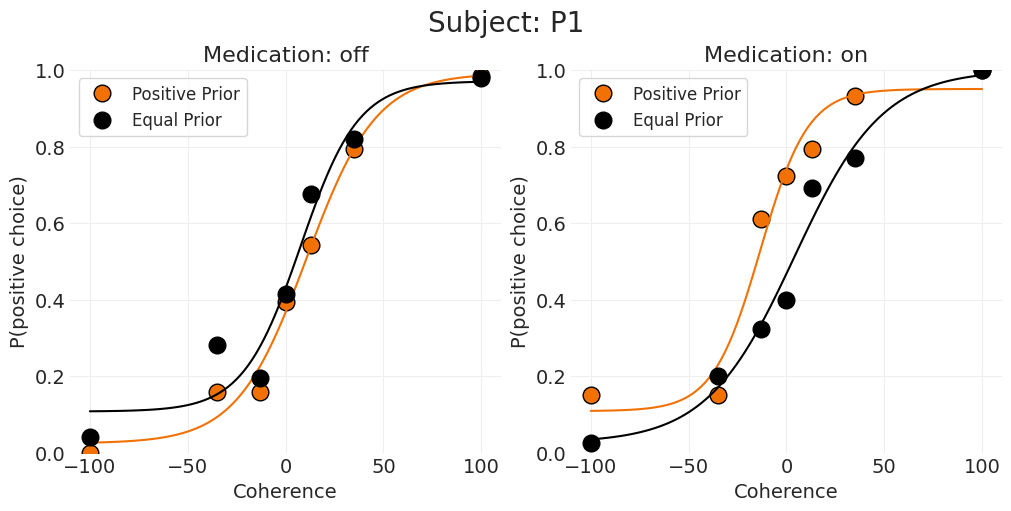

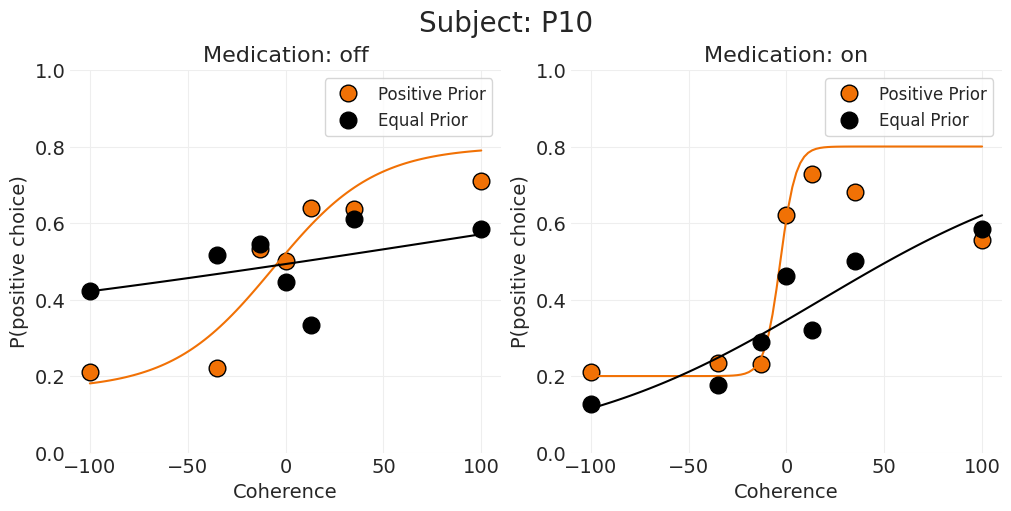

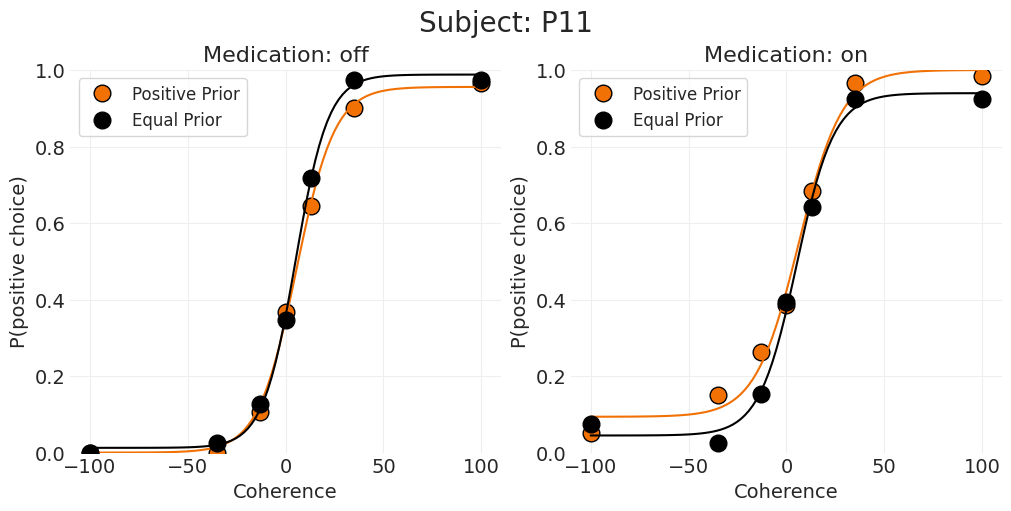

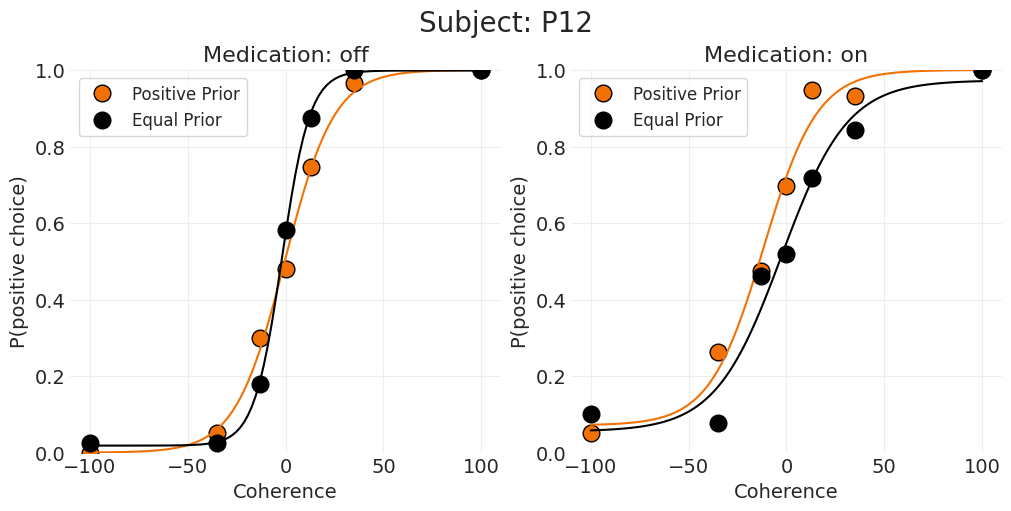

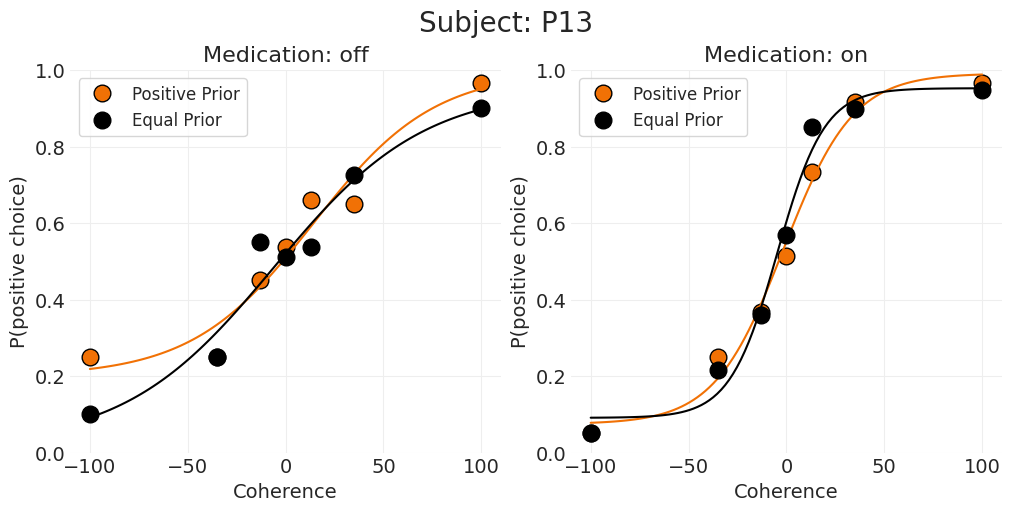

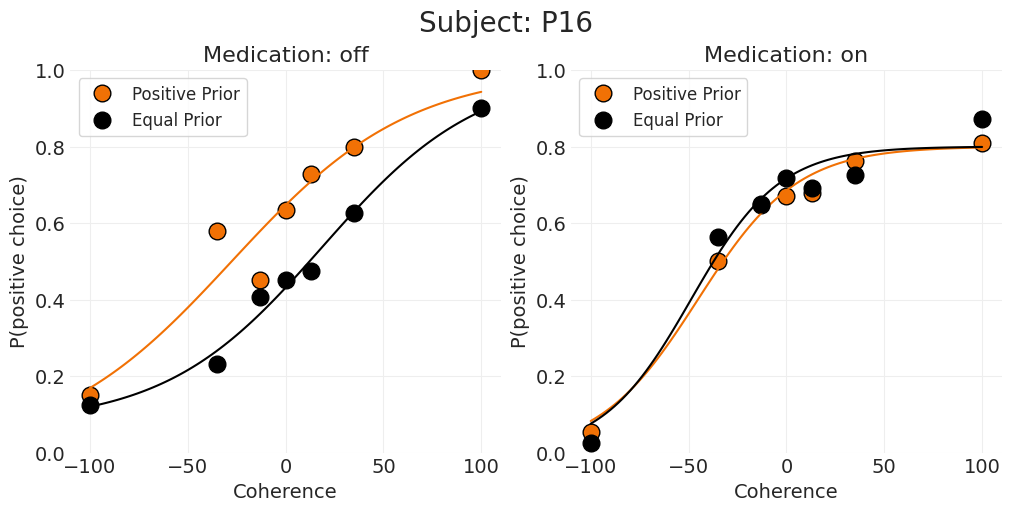

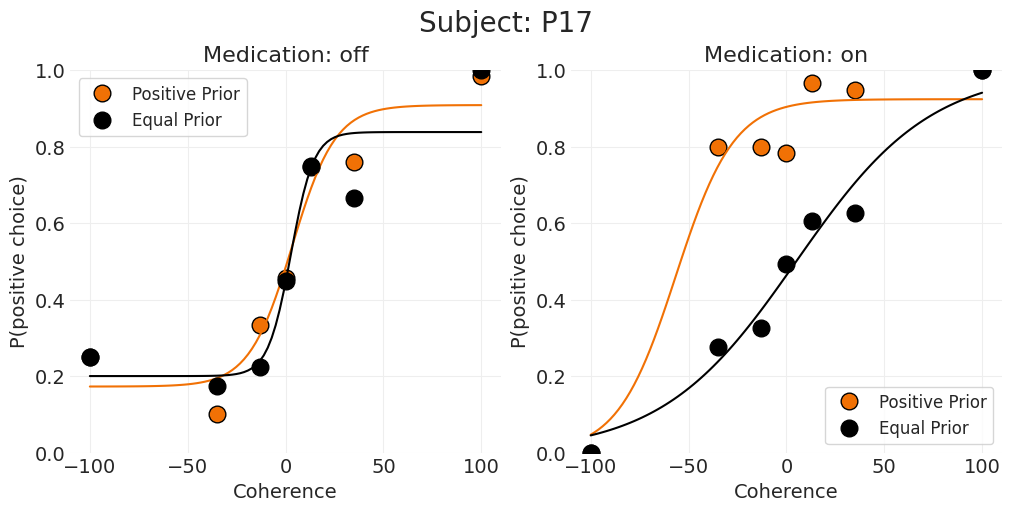

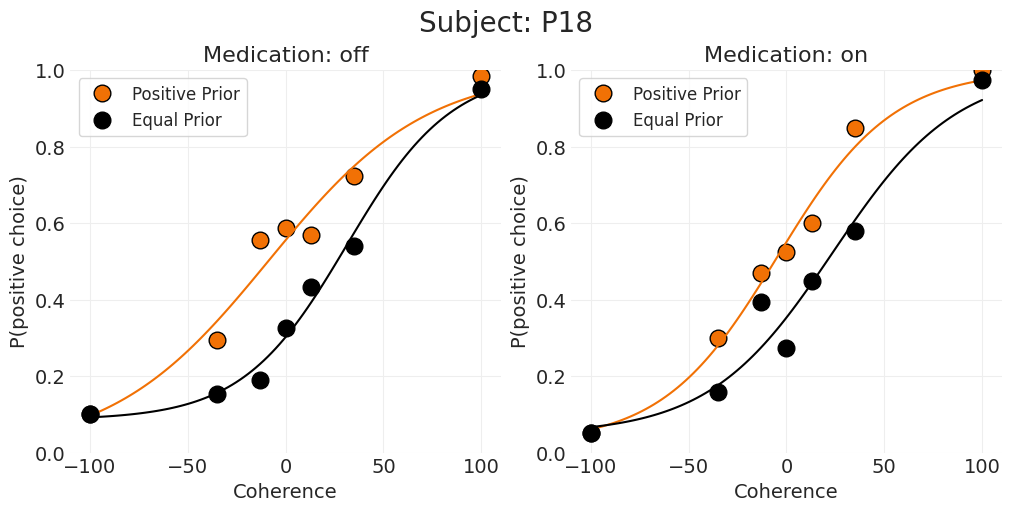

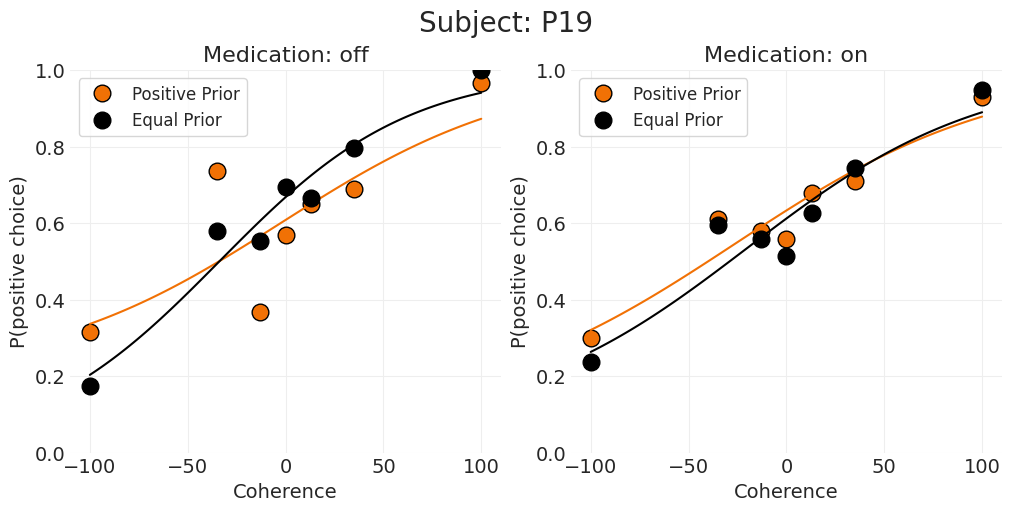

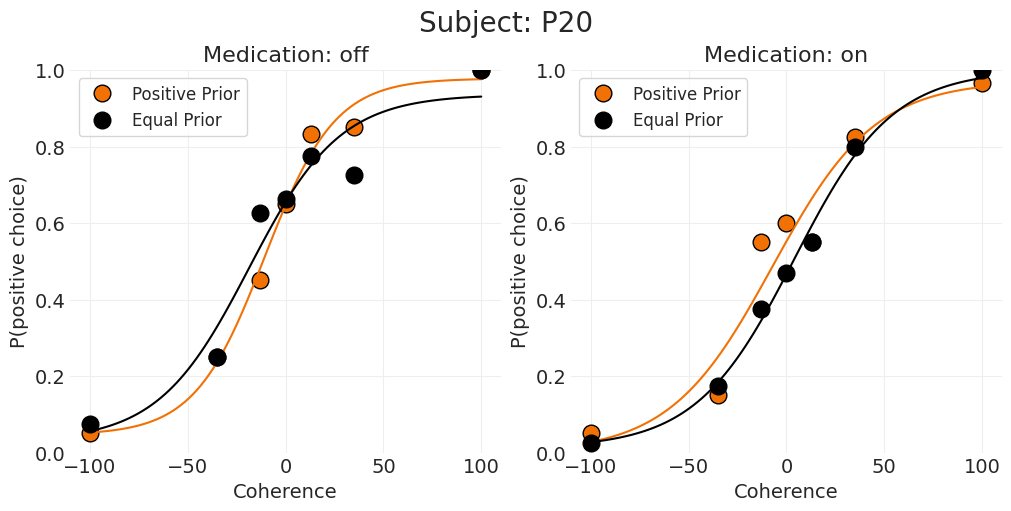

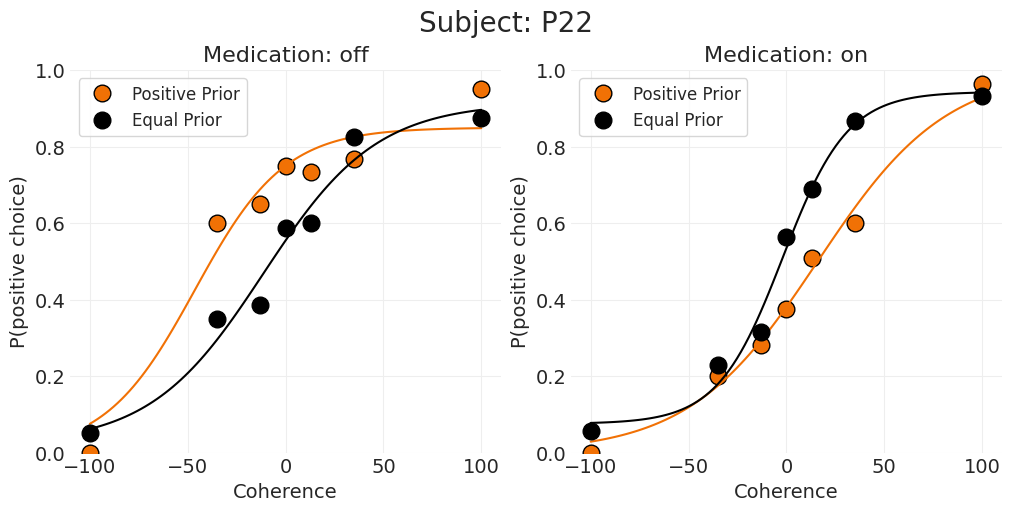

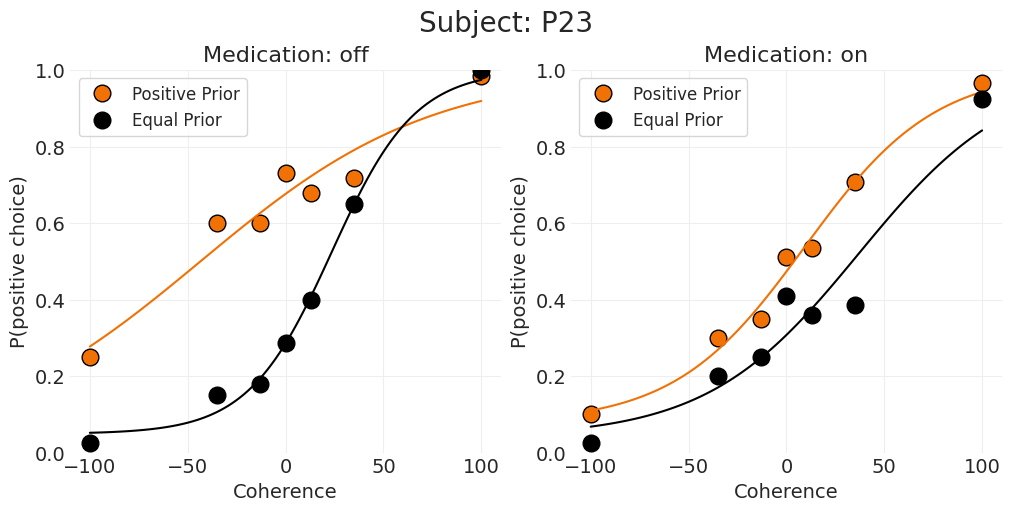

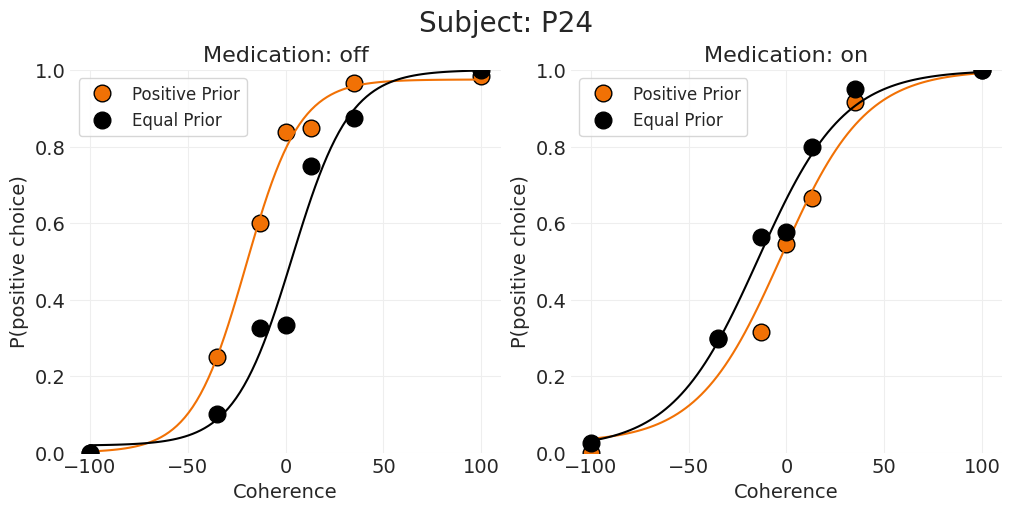

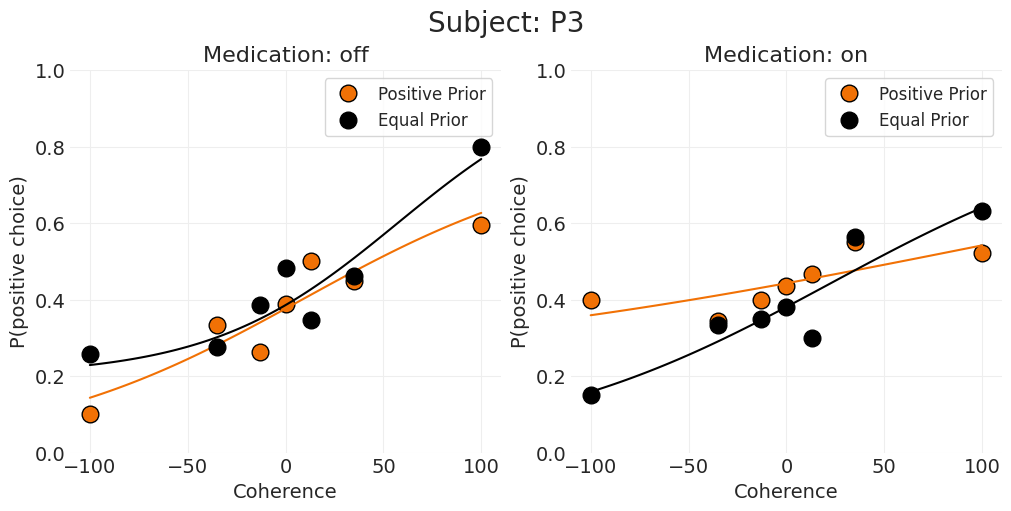

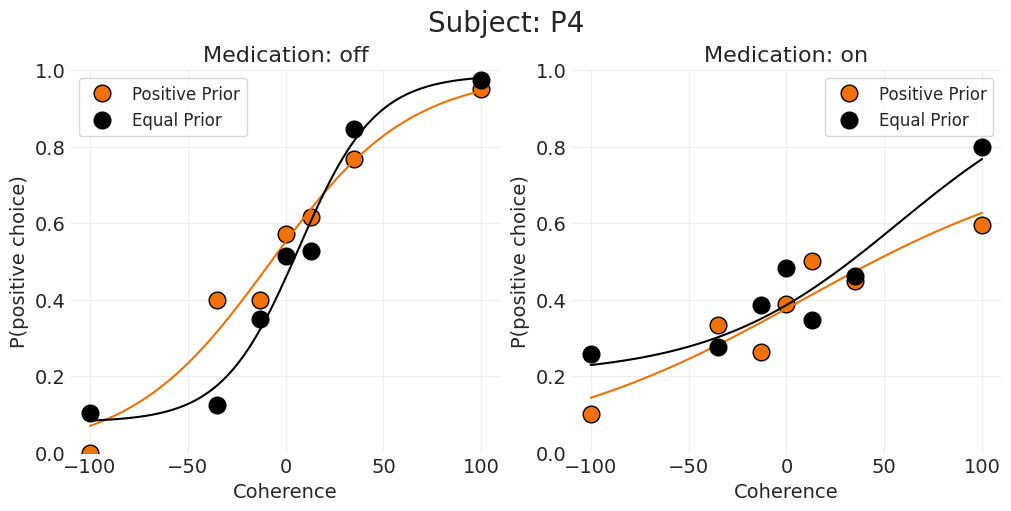

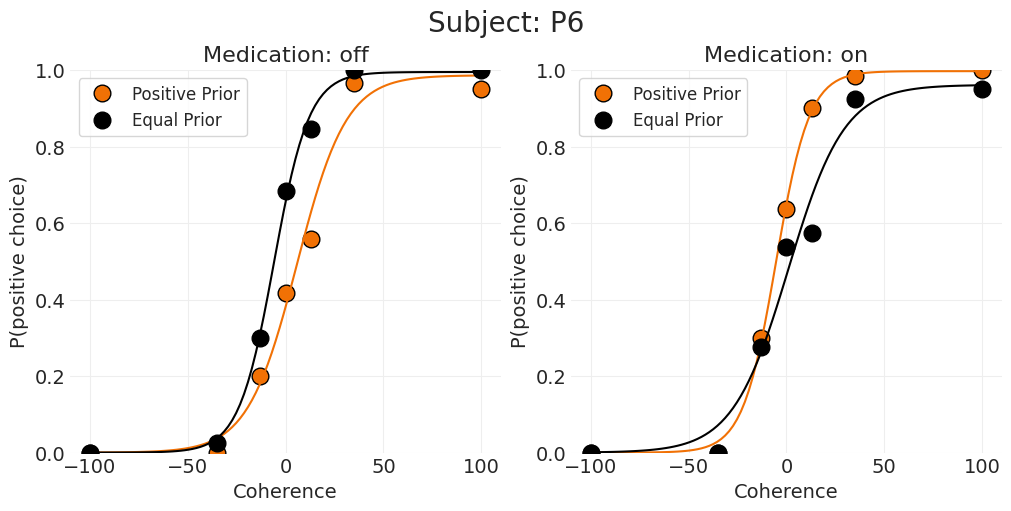

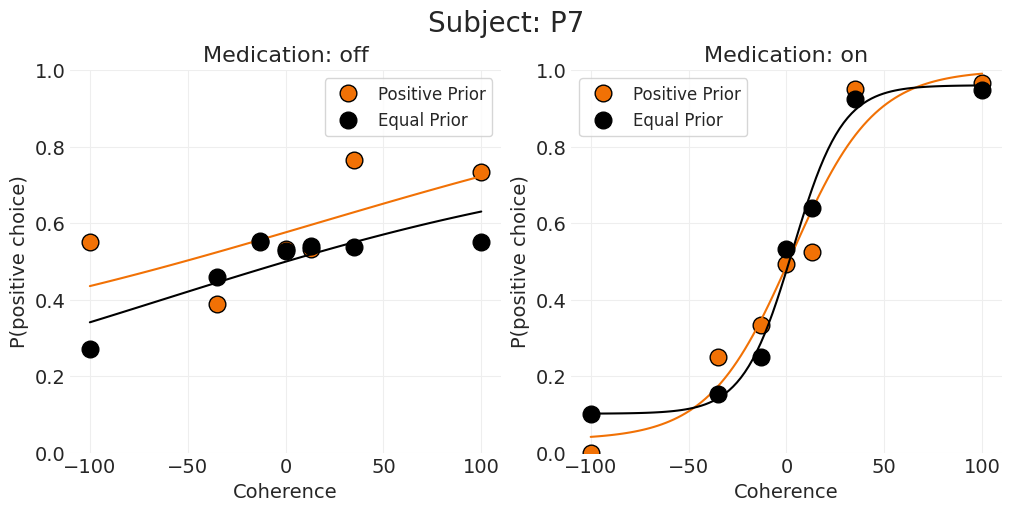

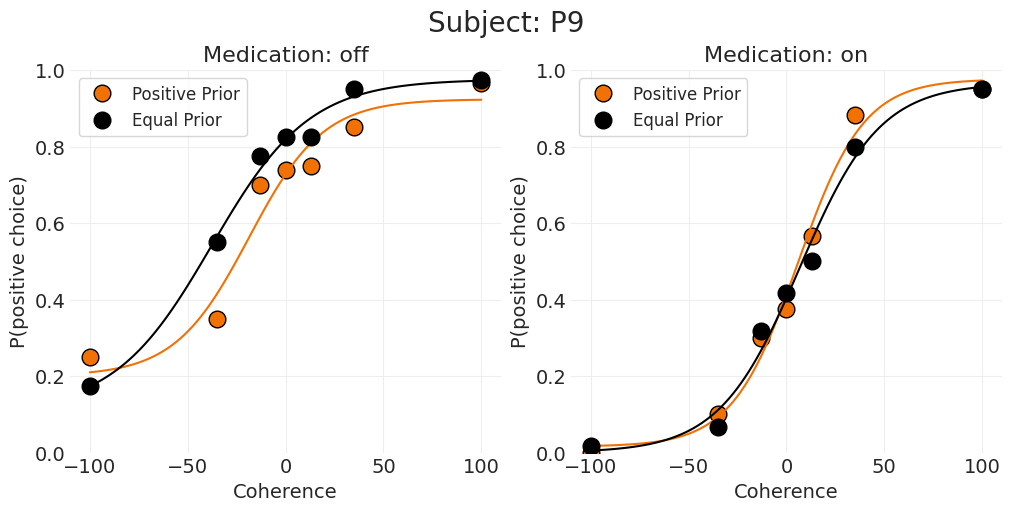

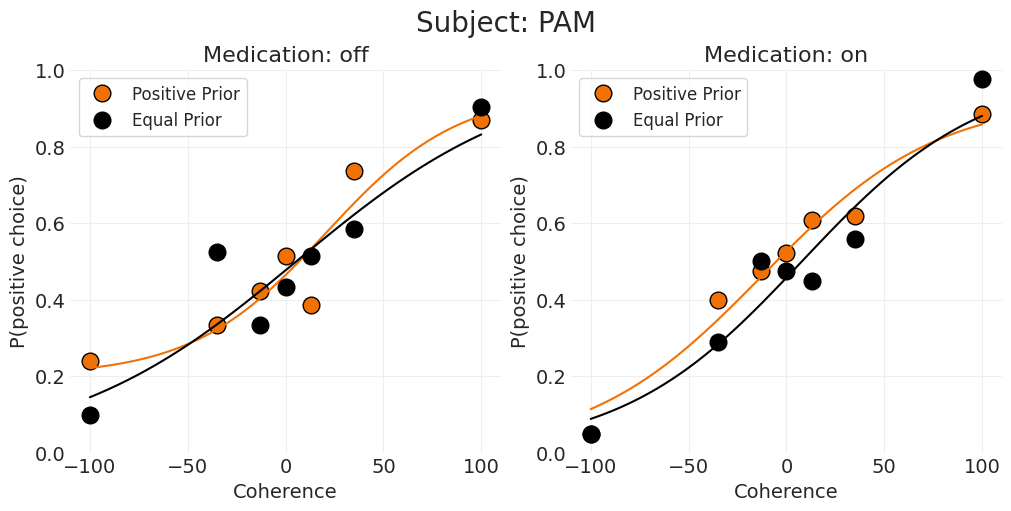

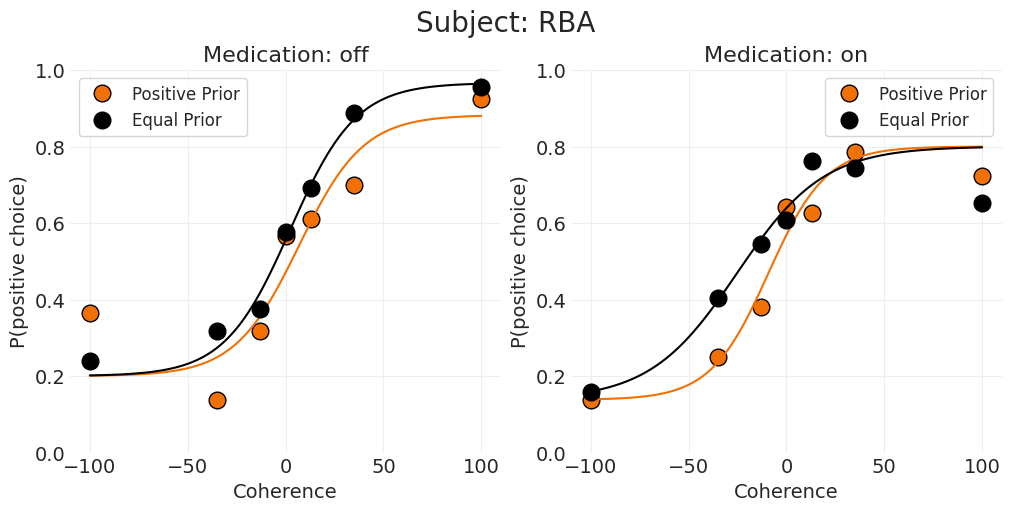

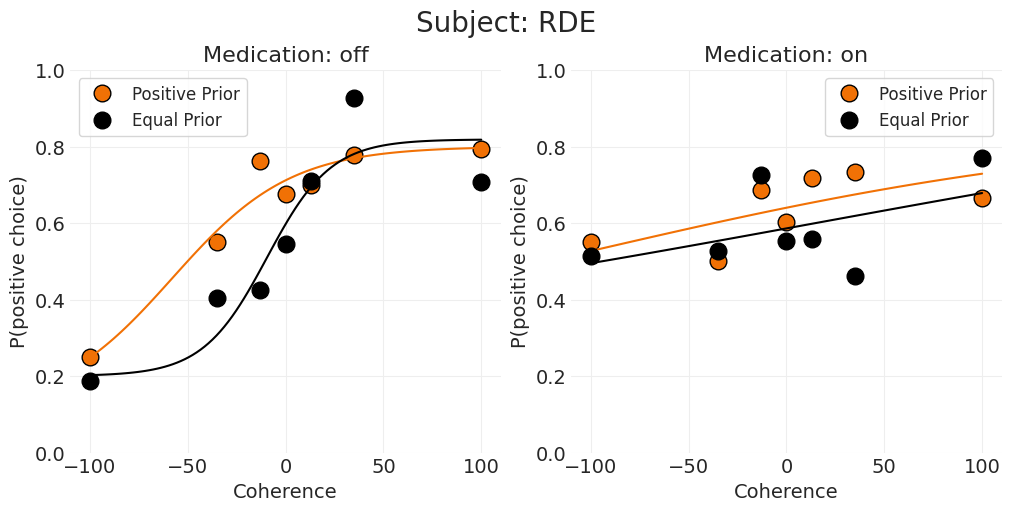

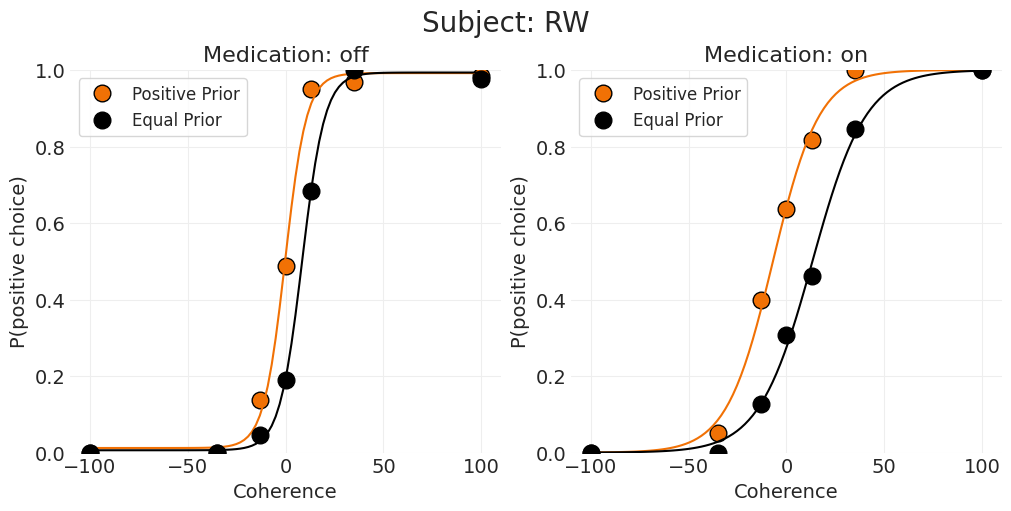

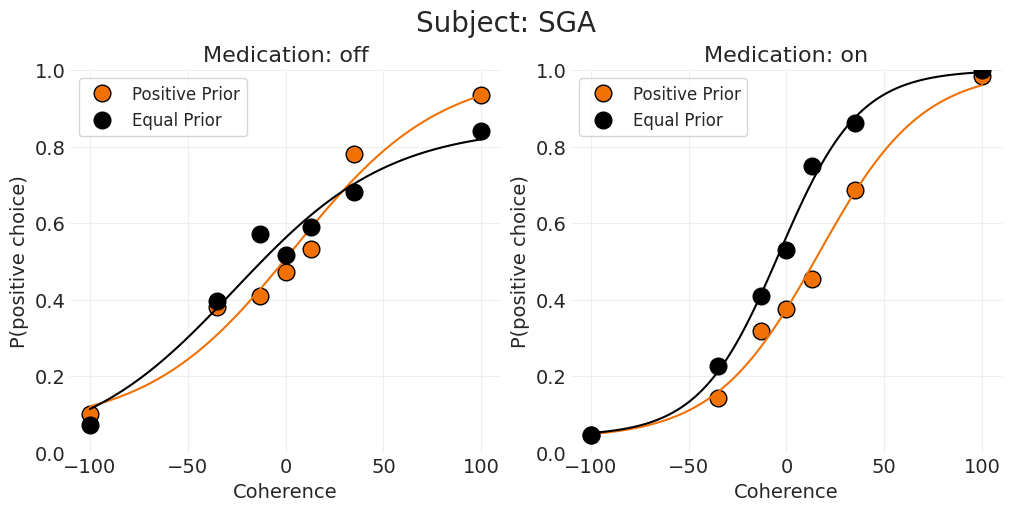

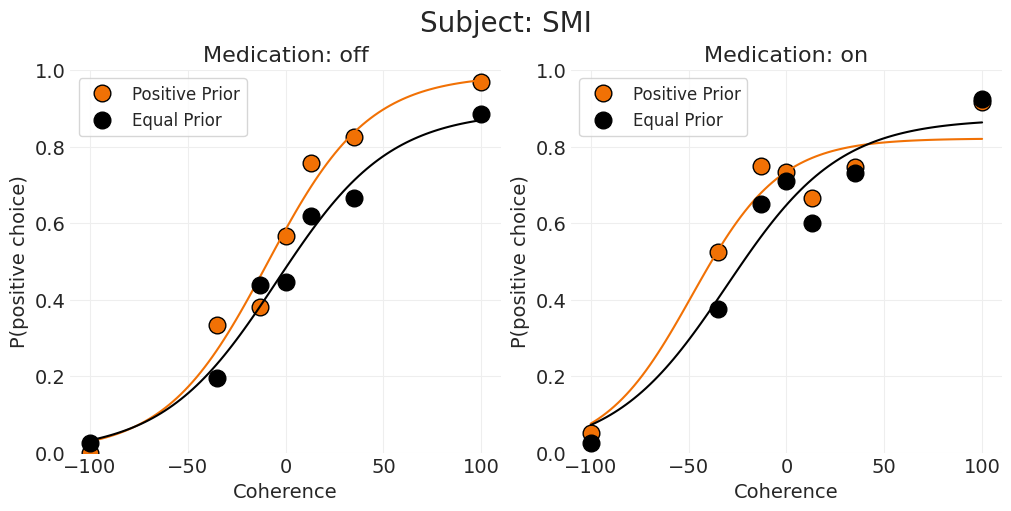

In [15]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

subject_alpha = 0.08
positive_color = 'C5'
equal_color = 'black'
error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

ax[idx].plot(pos_coh, pos_psych, color=positive_color, ls='', alpha=subject_alpha)
ax[idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
ax[idx].plot(eq_coh, eq_psych, color=equal_color, ls='', alpha=subject_alpha)
ax[idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)

for i, subject in enumerate(valid_subjects):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    subject_data = valid_data[valid_data['subject'] == subject]
    subject_data = subject_data.sort_values('medication')

    for idx, med in enumerate(subject_data['medication'].unique()):
        med_data = subject_data[subject_data['medication'] == med]
        coh, psych, model, x_hat, y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 1])
        ax[idx].plot(coh, psych, marker='o', ms=12, mec='k', color=positive_color, ls='', label='Positive Prior')
        ax[idx].plot(x_hat, y_hat, color=positive_color, ls='-')
        coh, psych, model, x_hat, y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == -1])
        ax[idx].plot(coh, psych, marker='o', ms=12, mec='k', color=equal_color, ls='', label='Equal Prior')
        ax[idx].plot(x_hat, y_hat, color=equal_color, ls='-')
        ax[idx].set_title(f"Medication: {med}", fontsize=16)
        ax[idx].set_xlabel('Coherence', fontsize=14)
        ax[idx].set_ylabel('P(positive choice)', fontsize=14)
        ax[idx].legend()
        ax[idx].set_ylim(0, 1)
        ax[idx].tick_params(axis='both', labelsize=14)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)

    fig.suptitle(f"Subject: {subject}", fontsize=20)

### Save data and data results (metadata)

In [16]:
# move file_name column to the end
cols = session_metadata.columns.tolist()
cols = cols[:4] + cols[5:] + [cols[4]]
session_metadata = session_metadata[cols]

session_metadata = session_metadata[session_metadata['subject_id'].isin(valid_subjects)]
valid_data = valid_data[valid_data['subject'].isin(valid_subjects)]

session_metadata.to_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index=False)
aggregate_data.to_csv(Path(processed_dir, "processed_data_accu_60_all.csv"), index=False)
valid_data.to_csv(Path(processed_dir, "processed_data_accu_60_filtered.csv"), index=False)